In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import glob
warnings.filterwarnings("ignore")

In [89]:
from PIL import Image
import numpy as np

def load_images_from_folder(folder_path, target_size=(256, 256), label = None):
    """
    Carga imágenes desde una carpeta, las redimensiona y las convierte en arrays.
    
    Args:
    - folder_path (str): Ruta de la carpeta que contiene las imágenes.
    - target_size (tuple): Tamaño al que se redimensionarán las imágenes (ancho, alto).

    Returns:
    - images_array (numpy.ndarray): Array de imágenes.
    - labels (list): Lista de nombres de archivo (opcionalmente puede ser la clase).
    """
    images_list = []  # Cambiamos el nombre a `images_list` para evitar confusión
    labels = []
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path) as img:
                # Redimensionar imagen al tamaño deseado
                img_resized = img.resize(target_size)
                # Convertir a array
                img_array = np.array(img_resized)
                # Asegurarse de que tiene 3 canales (RGB)
                if img_array.ndim == 2:  # Imagen en escala de grises
                    img_array = np.stack((img_array,) * 3, axis=-1)
                elif img_array.shape[-1] == 4:  # Imagen RGBA
                    img_array = img_array[..., :3]
                
                images_list.append(img_array)  # Agregar a la lista
                labels.append(label)  # Podrías extraer clases desde el nombre si es necesario
        except Exception as e:
            print(f"Error al cargar la imagen {file_path}: {e}")
    
    # Convertir la lista final a un array de NumPy
    images_array = np.array(images_list)
    return images_array, labels

In [280]:
##folder_path = "data_exercise/cristiano_ronaldo"
##images_array, labels = load_images_from_folder(folder_path, target_size=(128, 128), label = "cristiano_ronaldo")
images_array = np.empty((0, 256, 256, 3))
labels = []

In [281]:
for i in glob.glob('data_exercise/*'):
    images_array_, labels_ = load_images_from_folder(i, target_size=(256, 256), label = i.split('/')[1])
    images_array = np.concatenate((images_array, images_array_), axis=0)
    labels = labels + labels_

In [282]:
#### Preprocessing
#### Escalar las imágenes
from sklearn.model_selection import train_test_split
images_array_esc = images_array / 255.


x_train, x_test, y_train, y_test = train_test_split(images_array_esc, labels, test_size=0.3, random_state=123)
x_training, x_val, y_training, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

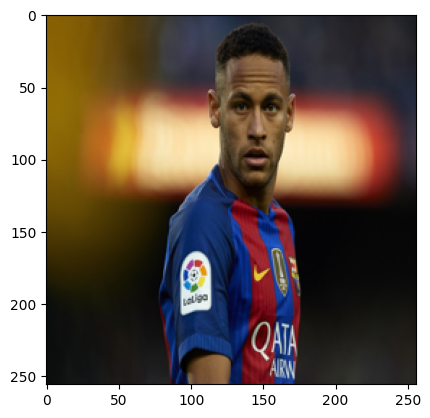

In [98]:
plt.imshow(x_train[12])

In [310]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [101]:
equivalencias = {
    'cristiano_ronaldo':0,
    'lionel_messi':1,
    'marco_reus':2,
    'mbappe':3,
    'neymar':4,
    'robert_lewandowski':5
}


In [287]:
y_train_cat = pd.get_dummies(y_training).values * 1
y_test_cat = pd.get_dummies(y_test).values * 1
y_val_cat = pd.get_dummies(y_val).values * 1

In [505]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load the pretrained VGG16 model
vgg_base = models.vgg16(pretrained=True)
for param in vgg_base.features.parameters():
    param.requires_grad = False  # Freeze the feature layers

# Define the custom VGG16 model
class CustomVGG16(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG16, self).__init__()
        self.vgg_features = vgg_base.features
        self.custom_layers = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=3, padding=1),  # 'conv_1'
            nn.ReLU(),
            nn.MaxPool2d(2),  # 'maxpool_1'
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 'conv_2'
            nn.ReLU(),
            nn.MaxPool2d(2),  # 'maxpool_2'
            nn.Dropout(0.5),  # 'dropout_1'
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 'conv_3'
            nn.ReLU(),
            nn.MaxPool2d(2),  # 'maxpool_3'
        )
        self.flatten = nn.Flatten()
        self.fc1 = None  # This will be initialized dynamically
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.vgg_features(x)
        x = self.custom_layers(x)
        x = self.flatten(x)
        
        # Dynamically initialize fc1 based on the input shape
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 64).to(x.device)
        
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Set number of classes
num_classes = 6

class ImageRecognition(CustomVGG16):
    
    def fit(self, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=30):
        best_accuracy = 0.0
        best_model_weights = None

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validation phase
            self.eval()
            val_accuracy = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_accuracy += torch.sum(preds == labels).item()

            val_accuracy /= len(val_loader.dataset)
            scheduler.step(val_accuracy)

            # Save the best model weights
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model_weights = self.state_dict()

            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Load best weights
        self.load_state_dict(best_model_weights)
        return self
#model = CustomVGG16(num_classes=num_classes)#.to(device)
model = ImageRecognition(num_classes=num_classes)
model.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

# Prepare datasets and dataloaders
batch_size = 32

# Assuming x_train, y_train_cat, x_test, y_test_cat are numpy arrays
x_train_tensor = torch.tensor(x_training, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to NCHW
y_train_tensor = torch.tensor(y_train_cat.argmax(axis=1), dtype=torch.long)  # Convert one-hot to class indices

x_val_tensor = torch.tensor(x_val, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to NCHW
y_val_tensor = torch.tensor(y_val_cat.argmax(axis=1), dtype=torch.long)  # Convert one-hot to class indices


x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to NCHW
y_test_tensor = torch.tensor(y_test_cat.argmax(axis=1), dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30):
    best_accuracy = 0.0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_accuracy += torch.sum(preds == labels).item()

        val_accuracy /= len(val_loader.dataset)
        scheduler.step(val_accuracy)

        # Save the best model weights
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_weights = model.state_dict()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Load best weights
    model.load_state_dict(best_model_weights)
    return model

# Train the model
#trained_model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)
model.fit(criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=30)


Epoch 1/30, Loss: 37.5256, Val Accuracy: 0.2256
Epoch 2/30, Loss: 36.1053, Val Accuracy: 0.2744


KeyboardInterrupt: 

Accuracy: 0.7094017094017094


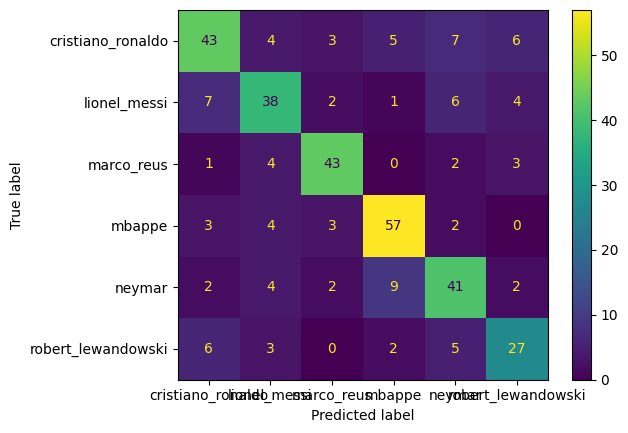

In [379]:
import numpy as np

# Set the model to evaluation mode
trained_model.eval()

# Use DataLoader for x_test to handle batch processing
test_loader = DataLoader(TensorDataset(x_test_tensor), batch_size=batch_size, shuffle=False)

# Store predictions
all_predictions = []

# Perform prediction
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)  # Extract the input batch and move to device
        outputs = trained_model(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get the predicted class
        all_predictions.extend(preds.cpu().numpy())  # Move to CPU and store

# Convert predictions to numpy array for further use
all_predictions = np.array(all_predictions)


accuracy = accuracy_score(y_test_tensor, all_predictions)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_tensor, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=equivalencias.keys())
disp.plot()


In [381]:
# Save the model's state dictionary
model_path = "/Users/aladelca/Library/CloudStorage/GoogleDrive-alarcon.adrianc@gmail.com/My Drive/portafolio/image_recognition/image_recognition/custom_vgg16.pth"
torch.save(trained_model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to /Users/aladelca/Library/CloudStorage/GoogleDrive-alarcon.adrianc@gmail.com/My Drive/portafolio/image_recognition/image_recognition/custom_vgg16.pth


In [ ]:
### Predict step
'''
class CustomVGG16(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG16, self).__init__()
        self.vgg_features = models.vgg16(pretrained=True).features
        self.custom_layers = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()

        # Dynamically determine the input size for fc1
        dummy_input = torch.zeros(1, 3, 256, 256)  # Dummy input with expected image size
        with torch.no_grad():
            dummy_output = self.vgg_features(dummy_input)
            dummy_output = self.custom_layers(dummy_output)
            flattened_size = dummy_output.numel()

        self.fc1 = nn.Linear(flattened_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.vgg_features(x)
        x = self.custom_layers(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x
'''
    
# Save the model's state dictionary
#torch.save(trained_model.state_dict(), "custom_vgg16.pth")

# Recreate the model
#num_classes = 6
#model = CustomVGG16(num_classes=num_classes)

# Load the state dictionary
#model.load_state_dict(torch.load("custom_vgg16.pth"))

# Set the model to evaluation mode
#model.eval()


In [383]:
# Set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Recreate the model
num_classes = 6
model = CustomVGG16(num_classes=num_classes).to(device)  # Move model to device

# Perform a dummy forward pass to initialize fc1 dynamically
dummy_input = torch.zeros(1, 3, 256, 256).to(device)  # Move input to the same device as the model
_ = model(dummy_input)

# Load the saved state dictionary
model.load_state_dict(torch.load("/Users/aladelca/Library/CloudStorage/GoogleDrive-alarcon.adrianc@gmail.com/My Drive/portafolio/image_recognition/image_recognition/custom_vgg16.pth", map_location=device))

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully and ready for inference.")

# Perform prediction
with torch.no_grad():
    output = model(x_test_tensor.to(device))
    _, predicted_class = torch.max(output, 1)
    print(predicted_class)

Model loaded successfully and ready for inference.
tensor([1, 1, 4, 5, 5, 0, 2, 4, 4, 0, 4, 3, 1, 2, 4, 3, 4, 2, 3, 1, 1, 1, 4, 1,
        4, 2, 0, 2, 0, 0, 1, 2, 3, 4, 4, 0, 3, 4, 5, 0, 2, 4, 2, 5, 3, 3, 0, 2,
        3, 3, 5, 4, 1, 0, 4, 1, 1, 2, 2, 0, 4, 5, 2, 3, 5, 2, 2, 0, 5, 3, 3, 1,
        5, 2, 3, 3, 1, 0, 2, 1, 3, 4, 4, 4, 3, 1, 0, 2, 5, 1, 2, 4, 4, 3, 5, 2,
        4, 2, 1, 3, 5, 1, 3, 2, 4, 4, 0, 2, 2, 5, 5, 0, 5, 2, 3, 5, 2, 0, 1, 0,
        4, 1, 0, 0, 1, 3, 0, 4, 4, 5, 3, 2, 5, 1, 4, 2, 5, 3, 5, 0, 1, 2, 5, 4,
        1, 3, 4, 3, 4, 4, 3, 1, 0, 3, 2, 0, 5, 4, 4, 2, 3, 4, 3, 2, 3, 3, 0, 5,
        1, 3, 2, 1, 0, 4, 1, 1, 4, 0, 1, 1, 1, 1, 3, 3, 0, 3, 1, 0, 0, 1, 1, 3,
        5, 3, 4, 0, 2, 1, 3, 3, 5, 4, 3, 0, 1, 2, 5, 0, 1, 1, 2, 3, 4, 2, 0, 5,
        4, 4, 1, 3, 4, 5, 0, 1, 2, 4, 5, 5, 1, 3, 3, 4, 0, 0, 3, 4, 4, 5, 3, 0,
        1, 2, 3, 4, 3, 2, 3, 0, 1, 1, 5, 4, 5, 3, 3, 2, 3, 0, 0, 4, 3, 0, 0, 3,
        0, 3, 0, 4, 0, 2, 4, 0, 5, 0, 0, 2, 4, 3, 0, 2, 5, 3, 1, 1, 5

In [495]:
import os
#os.chdir('src/')
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of model.neural_network failed: Traceback (most recent call last):
  File "/Users/aladelca/Library/Python/3.12/lib/python/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/aladelca/Library/Python/3.12/lib/python/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/aladelca/Library/Python/3.12/lib/python/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/aladelca/Library/Python/3.12/lib/python/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aladelca/Library/Python/3.12/lib/python/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/aladelca/Library/Python/3.12/lib/python/site-packages/IPython/e

In [496]:
from model.neural_network import ImageRecognition

In [498]:
modelo_loaded = ImageRecognition(num_classes=6).to(device)
#modelo_loaded.predict_from_load(x_test_tensor, "/Users/aladelca/Library/CloudStorage/GoogleDrive-alarcon.adrianc@gmail.com/My Drive/portafolio/image_recognition/image_recognition/custom_vgg16.pth" )

In [499]:
#modelo_loaded = ImageRecognition(device)
modelo_loaded.fit( criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Loss: 37.7185, Val Accuracy: 0.1707
Epoch 2/5, Loss: 37.7064, Val Accuracy: 0.1707
Epoch 3/5, Loss: 37.7067, Val Accuracy: 0.1707
Epoch 4/5, Loss: 37.7340, Val Accuracy: 0.1707
Epoch 5/5, Loss: 37.7303, Val Accuracy: 0.1707


ImageRecognition(
  (vgg_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

In [500]:
modelo_loaded.predict(x_test_tensor)

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x1 and 64x64)

In [392]:
modelo_loaded.predict(x_test_tensor)

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x1 and 64x64)